In [1]:
import pandas as pd


In [2]:
df=pd.read_csv("new_pcos_dataset.csv")


In [3]:
df.head()

,PCOS (Y/N),Follicle No. (R),Follicle No. (L),Skin darkening (Y/N),hair growth(Y/N),Weight gain(Y/N),Cycle length(days),AMH(ng/mL),Fast food (Y/N),Cycle(R/I),FSH/LH,PRL(ng/mL),Pimples(Y/N),Age (yrs),BMI
0,0,3,3,0,0,0,5,2.07,1.0,0,2.160326,45.16,0,28,19.3
1,0,5,3,0,0,0,5,1.53,0.0,0,6.174312,20.09,0,36,24.9
2,1,15,13,0,0,0,5,6.63,1.0,0,6.295455,10.52,1,33,25.3
3,0,2,2,0,0,0,5,1.22,0.0,0,3.415254,36.90,0,37,29.7
4,0,4,3,0,0,0,5,2.26,0.0,0,4.422222,30.09,0,25,20.1


In [4]:
X=df.drop(["PCOS (Y/N)"],axis=1)
y = df[["PCOS (Y/N)"]]

In [5]:
X.shape


(540, 14)

In [6]:
y.shape


(540, 1)

In [7]:
from imblearn.combine import SMOTEENN

resample = SMOTEENN(sampling_strategy=1/1, random_state =0)
X, y = resample.fit_resample(X, y)

In [8]:
X.shape


(527, 14)

In [9]:
y.shape


(527, 1)

In [10]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from sklearn.metrics import confusion_matrix

In [12]:
from yellowbrick.classifier import confusion_matrix

def vis_conf(model, X_test, y_test):
    plt.figure(figsize=(6, 5))
    visualizer = confusion_matrix(
        model,
        X_test, y_test,
        is_fitted=True,
        classes=['Negative', 'Positive']
    )
    visualizer.show();

In [15]:
def test_results(model, X_test, y_test):
    from sklearn.metrics import confusion_matrix
    y_pred = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = (tp + tn)/(tp + fp + tn + fn)
    print("Accuracy: ", '{:.2f}'.format(accuracy * 100))
    print("True Negative:", tn)
    print("True Positve:", tp)
    print("False Positive:", fp)
    print("False Negative:", fn)
    print()
    print("-------------------------------------------------------")
    print("Negative Class Results")
    precision = (tp / (tp + fp)) 
    recall =  (tp  / (tp + fn)) 
    f1_score = (2 * (precision * recall) / (precision + recall)) 
    print("Precision (N): ", '{:.2f}'.format(precision * 100))
    print("Recall (N): ", '{:.2f}'.format(recall * 100))
    print("F1 Score (N):" ,  '{:.2f}'.format(f1_score * 100))
    print()
    print("-------------------------------------------------------")
    print("Positive Class Results")
    precision = (tn / (tn + fn))
    recall =  (tn  / (tn + fp))
    f1_score = (2 * (precision * recall) / (precision + recall))
    print("Precision (P): ", '{:.2f}'.format(precision * 100))
    print("Recall (P): ", '{:.2f}'.format(recall * 100))
    print("F1 Score (P):" , '{:.2f}'.format(f1_score * 100))

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)


In [101]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import joblib

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)


# Setting Column Names from dataset
X_train.columns = X.columns
X_test.columns = X.columns

scaler_filename = "scaler.pkl"
joblib.dump(scaler, scaler_filename)

print(f"Scaler has been saved as {scaler_filename}")


Scaler has been saved as scaler.pkl


In [102]:
from sklearn.svm import SVC


In [103]:
svm = SVC(kernel="linear", gamma='auto', probability= True, random_state=0)


In [104]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Kernel types
}

In [105]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=SVC(probability=True, random_state=0), 
                           param_grid=param_grid, 
                           cv=5, 
                           verbose=2, 
                           n_jobs=-1, 
                           scoring='f1_weighted')

In [106]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=0), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='f1_weighted', verbose=2)

In [107]:
print("Best Hyperparameters from GridSearchCV:", grid_search.best_params_)


Best Hyperparameters from GridSearchCV: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}


In [108]:
best_svm = grid_search.best_estimator_


In [109]:
test_results(best_svm, X_test, y_test)


Accuracy:  94.34
True Negative: 48
True Positve: 52
False Positive: 3
False Negative: 3

-------------------------------------------------------
Negative Class Results
Precision (N):  94.55
Recall (N):  94.55
F1 Score (N): 94.55

-------------------------------------------------------
Positive Class Results
Precision (P):  94.12
Recall (P):  94.12
F1 Score (P): 94.12


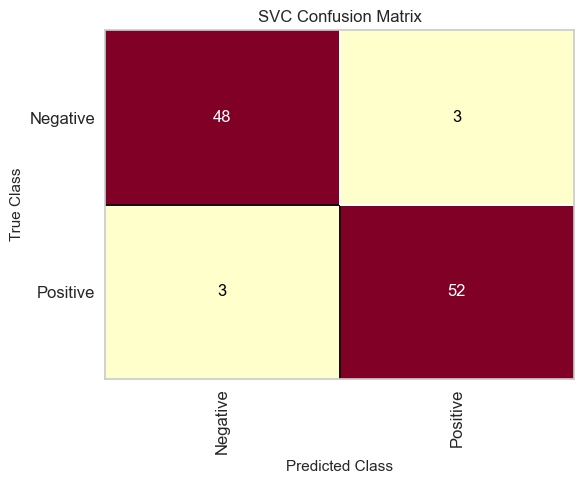

In [110]:
from yellowbrick.classifier import confusion_matrix as viz_conf

# Confusion Matrix Visualization
def vis_conf(model, X_test, y_test):
    plt.figure(figsize=(6, 5))
    visualizer = viz_conf(
        model,
        X_test, y_test,
        is_fitted=True,
        classes=['Negative', 'Positive']
    )
    visualizer.show()

vis_conf(best_svm, X_test, y_test)


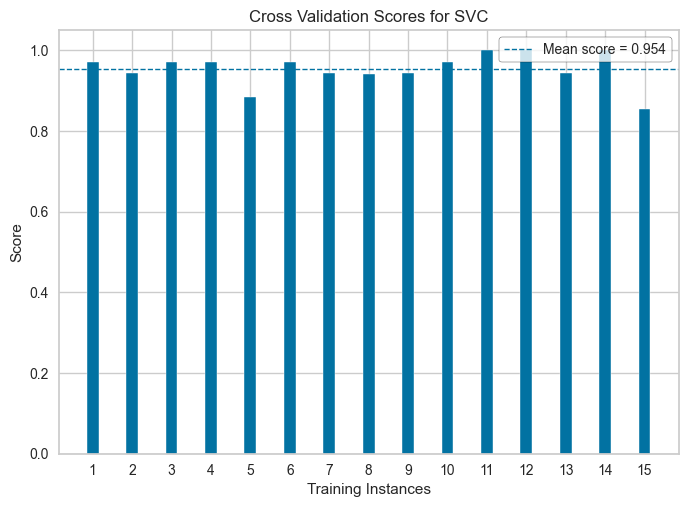

<Axes: title={'center': 'Cross Validation Scores for SVC'}, xlabel='Training Instances', ylabel='Score'>

In [ ]:

cv = StratifiedKFold(
    n_splits=15,random_state=0,
    shuffle=True
) 
visualizer = CVScores(svm, cv=cv, scoring='f1_weighted', is_fitted=False, stratify = True)
visualizer.fit(X, y)        
visualizer.show()           

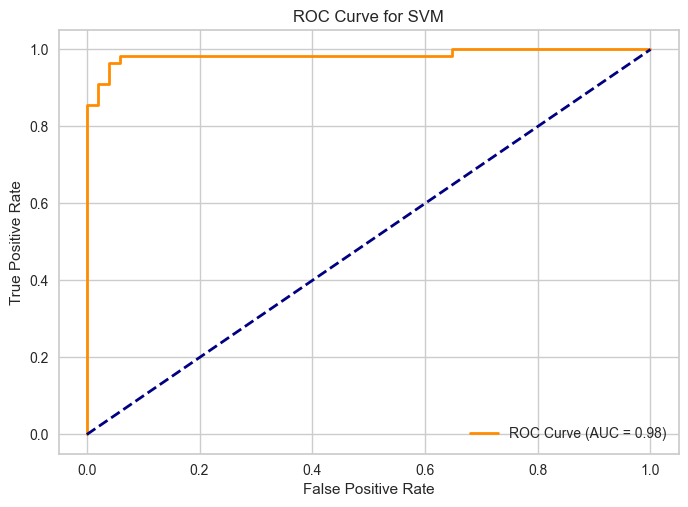

AUC: 0.98


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Training the SVM model
svc = SVC(kernel="linear", gamma="auto", probability=True, random_state=0)
svc.fit(X_train, y_train)


y_prob = svc.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for SVM")
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.2f}")


In [41]:
from sklearn.linear_model import LogisticRegression


In [42]:
lr_model = LogisticRegression(
    solver='liblinear',   # Solver suitable for small to medium datasets
    random_state=0, 
    class_weight=None     # SMOTEENN has already balanced the data
)


In [43]:
lr_model.fit(X_train, y_train)


LogisticRegression(random_state=0, solver='liblinear')

In [44]:
test_results(lr_model, X_test, y_test)


Accuracy:  96.23
True Negative: 49
True Positve: 53
False Positive: 2
False Negative: 2

-------------------------------------------------------
Negative Class Results
Precision (N):  96.36
Recall (N):  96.36
F1 Score (N): 96.36

-------------------------------------------------------
Positive Class Results
Precision (P):  96.08
Recall (P):  96.08
F1 Score (P): 96.08


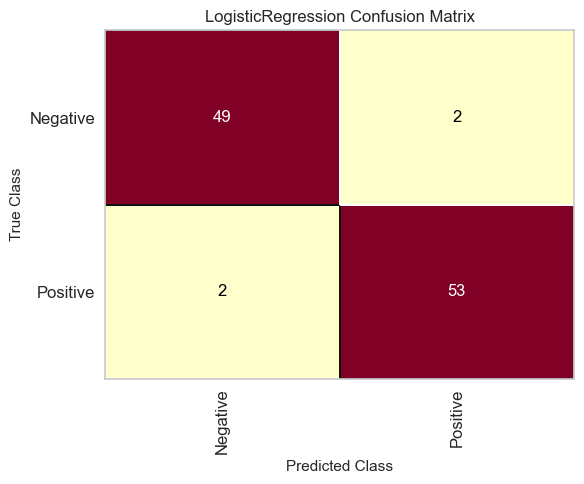

In [45]:
vis_conf(lr_model, X_test, y_test)


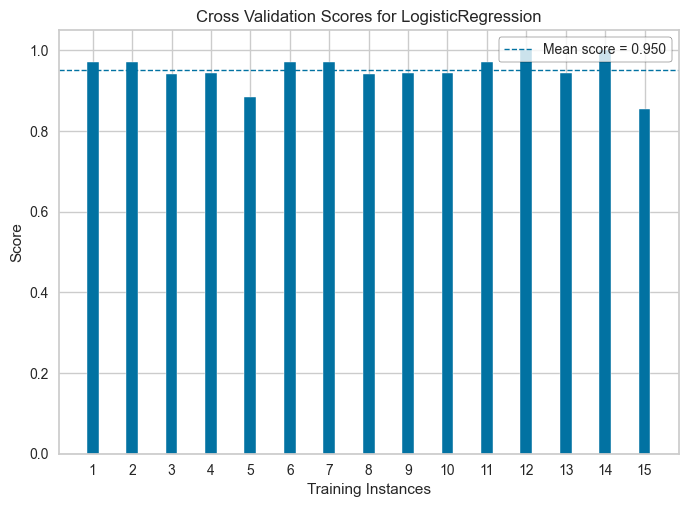

<Axes: title={'center': 'Cross Validation Scores for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [46]:
cv = StratifiedKFold(n_splits=15, random_state=0, shuffle=True)
visualizer = CVScores(lr_model, cv=cv, scoring='f1_weighted', is_fitted=False, stratify=True)
visualizer.fit(X, y)
visualizer.show()

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [54]:
param_grid = {
    'criterion': ['gini', 'entropy'],   # Criterion for splitting nodes
    'max_depth': [None, 5, 10, 20, 30], # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5, 10], # Minimum samples required at a leaf node
}

In [64]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20, None],  # Broader range of tree depths
    'min_samples_split': [2, 5, 10, 20],  # Larger minimum samples to split
    'min_samples_leaf': [1, 2, 5, 10]  # Larger minimum samples per leaf
}

In [65]:
dt_model = DecisionTreeClassifier(random_state=0)


In [66]:
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,  # 5-fold cross-validation
    n_jobs=-1
)

In [67]:
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 10, 20, None],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='f1_weighted')

In [68]:
best_params = grid_search.best_params_
print("Best Hyperparameters from GridSearchCV:", best_params)

Best Hyperparameters from GridSearchCV: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [69]:
best_dt_model = grid_search.best_estimator_
best_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

Accuracy:  93.40
True Negative: 47
True Positve: 52
False Positive: 4
False Negative: 3

-------------------------------------------------------
Negative Class Results
Precision (N):  92.86
Recall (N):  94.55
F1 Score (N): 93.69

-------------------------------------------------------
Positive Class Results
Precision (P):  94.00
Recall (P):  92.16
F1 Score (P): 93.07


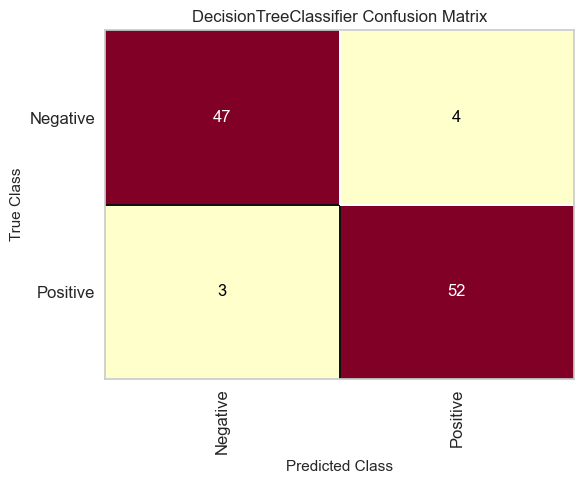

In [70]:
test_results(best_dt_model, X_test, y_test)
vis_conf(best_dt_model, X_test, y_test)

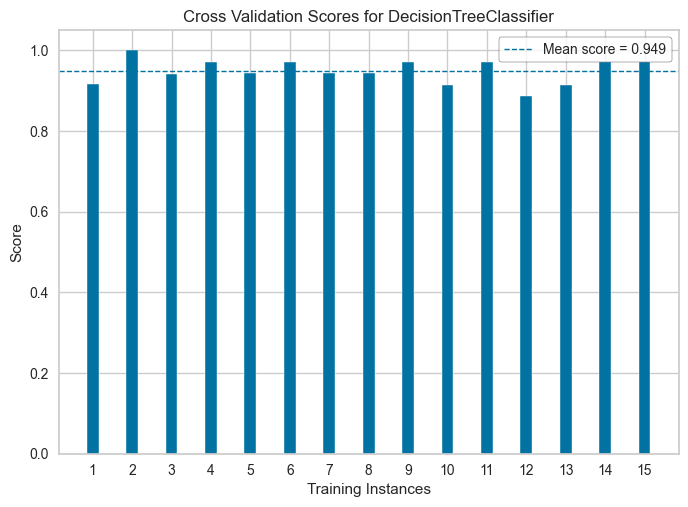

<Axes: title={'center': 'Cross Validation Scores for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [71]:
cv = StratifiedKFold(n_splits=15, random_state=0, shuffle=True)
visualizer = CVScores(dt_model, cv=cv, scoring='f1_weighted', is_fitted=False, stratify=True)
visualizer.fit(X, y)
visualizer.show()

In [85]:
import pickle
# Save the model to a .pkl file
filename = 'Support_Vector_Model1.pkl'  # Name of the .pkl file
pickle.dump(best_svm, open(filename, 'wb'))

# Load the model from the .pkl file
loaded_model_svc = pickle.load(open(filename, 'rb'))

In [86]:
import numpy as np


input_data = np.array([[8,15,1,1,1,2,7.94,1.0,1,1.3245033112582782,22.43,1,25,32.0

]])  



In [87]:

prediction = loaded_model_svc.predict(input_data)
print(prediction)  # This will print the predicted class/label


[1]


In [88]:
predicted_value = loaded_model_svc.predict(input_data)
print(predicted_value)  # This will print the predicted continuous value

[1]


In [89]:
if prediction == 1:
    print("PCOS Detected")
else:
    print("No PCOS")

PCOS Detected


In [90]:
import pickle
# Saving the model to a .pkl file
filename = 'LR1.pkl'  # Name of the .pkl file
pickle.dump(lr_model, open(filename, 'wb'))

# Load the model from the .pkl file
loaded_model_lr = pickle.load(open(filename, 'rb'))

In [91]:
import numpy as np


input_data = np.array([[8,15,1,1,1,2,7.94,1.0,1,1.3245033112582782,22.43,1,25,32.0

]])  


In [93]:

prediction = loaded_model_lr.predict(input_data)
print(prediction)  # This will print the predicted class/label

[1]


In [95]:
predicted_value = loaded_model_lr.predict(input_data)
print(predicted_value) 

[1]


In [96]:
if prediction == 1:
    print("PCOS Detected")
else:
    print("No PCOS")

PCOS Detected


In [98]:
import pickle
import numpy as np

# Saving the Decision Tree model to a .pkl file
filename = 'Decision_Tree_Model1.pkl'
pickle.dump(best_dt_model, open(filename, 'wb'))

# Load the model from the .pkl file
loaded_model_dt = pickle.load(open(filename, 'rb'))

input_data = np.array([[8, 15, 1, 1, 1, 2, 7.94, 1.0, 1, 1.3245033112582782, 22.43, 1, 25, 32.0]])


# Make predictions
prediction = loaded_model_dt.predict(input_data)
print(prediction)  # This will print the predicted class/label

# Print the predicted value
predicted_value = loaded_model_dt.predict(input_data)
print(predicted_value)

if prediction == 1:
    print("PCOS Detected")
else:
    print("No PCOS")

[1]
[1]
PCOS Detected
